In [24]:
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D

In [10]:
%config InlineBackend.figure_format = "retina"

In [11]:
color = "#5A5A5A"

In [12]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

In [13]:
jnp.exp(3) / 20

Array(1.0042769, dtype=float32, weak_type=True)

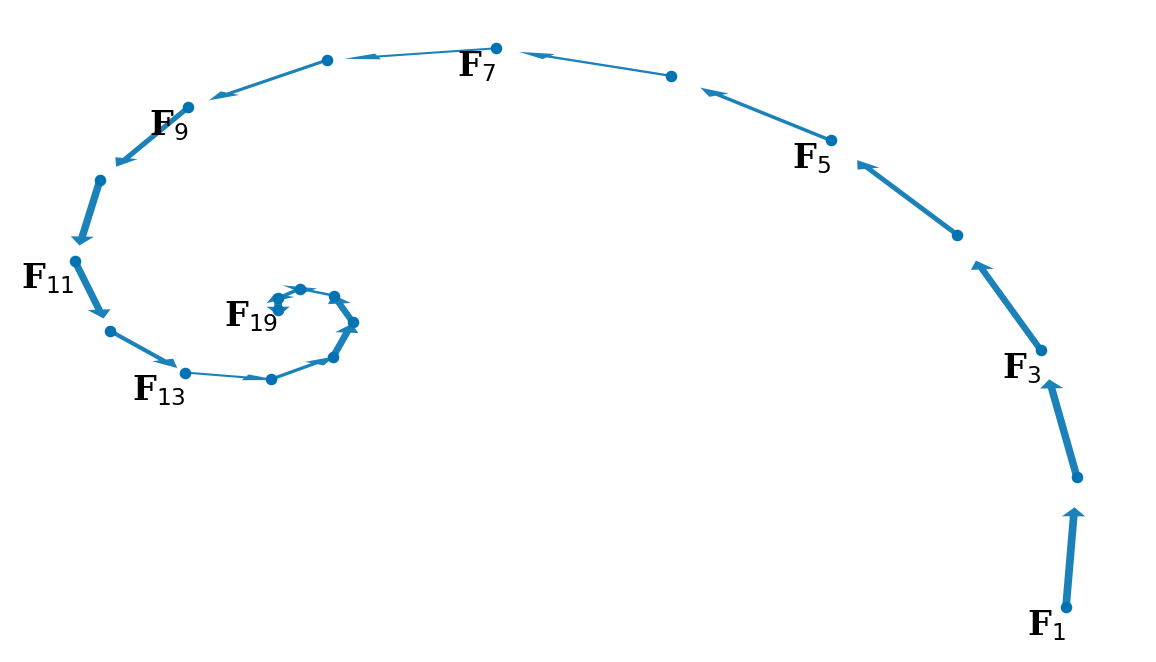

In [14]:
def f(x, t):
    x, y = x
    ẋ = -(x + y)
    ẏ = 6 * x - y
    return ẋ, ẏ
time = np.linspace(0, np.exp(3), 20)
time = np.exp(0.08163265) ** time
X = odeint(f, np.array([1.0, -1.5]), t=time)
plt.scatter(*X.T, s=10)

for i, (init, end) in enumerate(zip(X[:-1], X[1:])):
    Δx = end - init
    plt.arrow(*init, *Δx * 0.7, head_width=0.03, edgecolor="None", width=0.01, alpha=0.9)
    if i in [0, 2, 4, 6,8, 10, 12, 18]:
        plt.text(*init, r"F$_{"f"{i+1}""}$", horizontalalignment="right",
                 verticalalignment="top",
                 fontsize=12,
                 family="serif",
                 weight="bold"
                )
# plt.grid(alpha=0.3)
plt.axis("off")
plt.savefig("./discrete-dynamical-system.png", dpi=200, bbox_inches="tight")

# Linear dynamical system

In [15]:
c0, c1 = sns.color_palette()[:2]

c0 = "#5A5A5A"
c1 = "#DC143C"

custom_lines = [
    Line2D([0], [0], color=c0, lw=2),
    Line2D([0], [0], color=c1, lw=2)
]

In [116]:
F_fwd = jnp.array([
    [1, 0],
    [0, 1]
])

F_change = jnp.array([
    [-1, -1],
    [6, -1]
]) * dt

F = jnp.c_[F_fwd, F_change]

H = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
]) * 1.0

In [170]:
F = jnp.array([
    [1, 0, -dt, 0],
    [0, 1, 0, -dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

In [308]:
T = 5
n_steps = 1000
dt = T / n_steps

F = np.array([
    [1 - dt, -dt],
    [6 * dt, 1 - dt]
])

F = jnp.array([
    [1 - dt + (dt**2) / 2, -dt + (dt**2)],
    [6 * dt - 6 * (dt**2), 1 - dt + (dt**2) / 2]
])


H = jnp.eye(2)
R = np.eye(2) * 0.001
Q = np.eye(2) * 0.0

In [309]:
def step(theta, key, F, H, dt):
    key_noise, key_dynamics = jax.random.split(key)
    noise = jnp.sqrt(R) @ jax.random.normal(key_noise, (H.shape[0],))
    latent_noise = jnp.sqrt(Q) @ jax.random.normal(key_dynamics, (F.shape[0],))
    theta_new = F @ theta + latent_noise * jnp.sqrt(dt)
    signal = H @ theta_new
    measurement = signal + noise
    return theta_new, (signal, measurement)


def simulate(key, latent_init, T, n_steps):
    dt = T / n_steps
    keys = jax.random.split(key, n_steps)
    F = jnp.array([
        [1 - dt + (dt**2) / 2, -dt + (dt**2)],
        [6 * dt - 6 * (dt**2), 1 - dt + (dt**2) / 2]
    ])

    pstep = partial(step, F=F, H=H, dt=dt)
    _, (signal, measurement) = jax.lax.scan(pstep, theta_init, keys)
    return {
        "signal": signal,
        "measurement": measurement
    }

In [310]:
theta_init = jnp.array([1.0, -1.5])
key = jax.random.PRNGKey(314)

T = 5
n_steps = 1000
res = simulate(key, theta_init, T, n_steps)

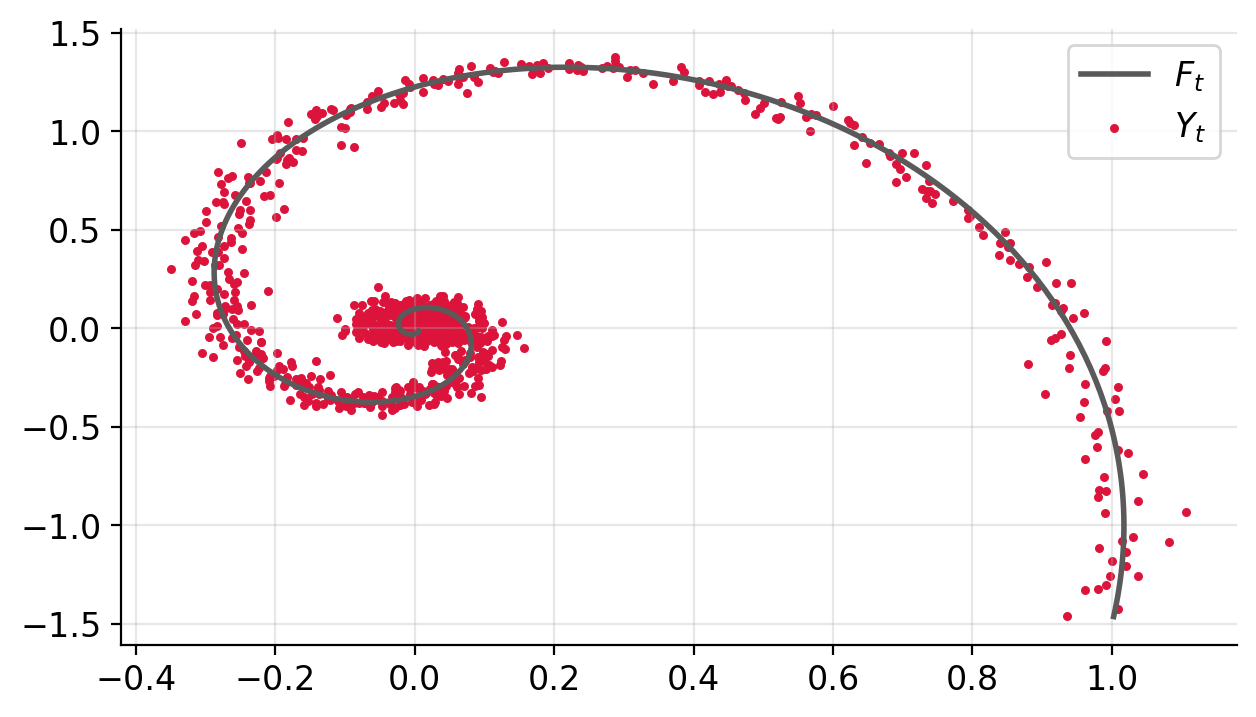

In [311]:
plt.plot(*res["signal"].T, color=c0, linewidth=2, label="$F_t$")
plt.scatter(*res["measurement"].T, c=c1, alpha=1.0, zorder=0, s=5, label="$Y_t$")
plt.legend()
plt.grid(alpha=0.3)

### Multiple simulations

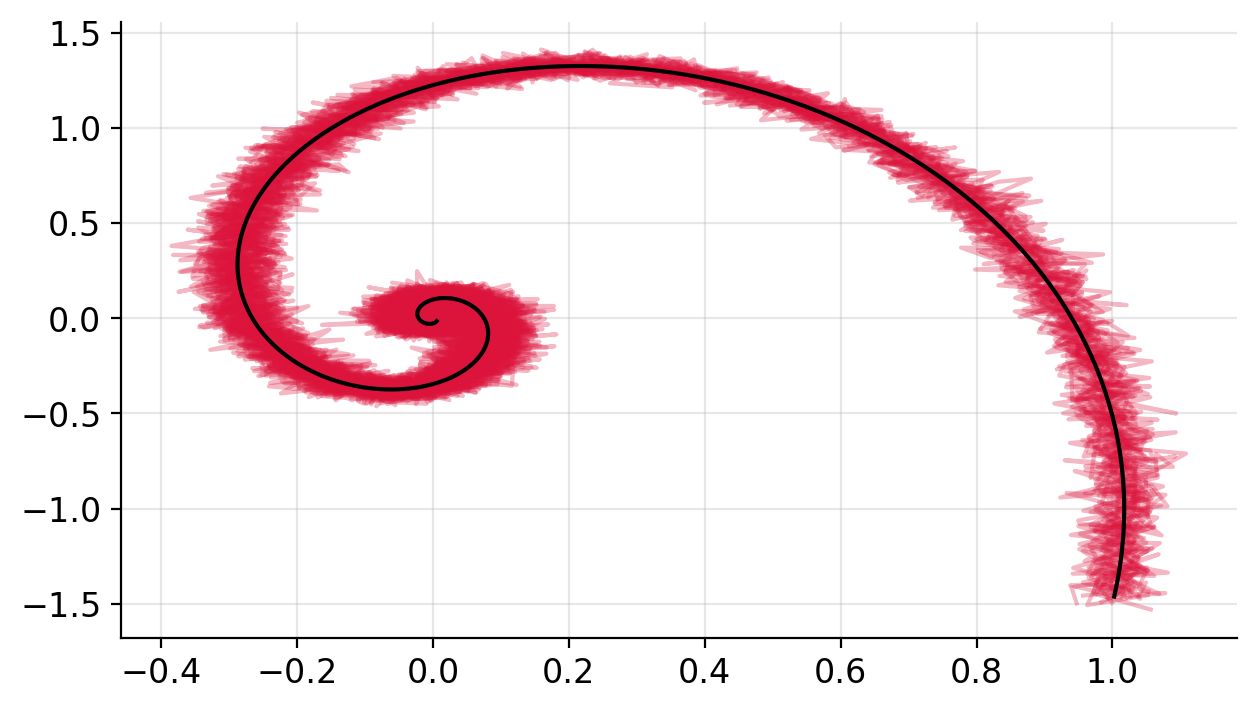

In [312]:
n_sims = 20
key_sims = jax.random.split(key, n_sims)
vsim = jax.vmap(simulate, in_axes=(0, None, None, None))
res = vsim(key_sims, theta_init, T, n_steps)

for sim in res["measurement"]:
    plt.plot(*sim.T, c=c1, alpha=0.3)
plt.plot(*res["signal"][0].T, c="black")
plt.grid(alpha=0.3)